In [1]:
import sys
sys.path.append("..")
sys.path.append("../ADsurf")
sys.path.append("../ADsurf/_cps")
from ADsurf._ADsurf import *

data_path = "./data/02_FRIUL7W/"
model = Model()

## 1. Model parameter

In [2]:
dc   = 0.01
vmin = 0.5
vmax = 5.0
tmin = 1/20
tmax = 5
layering_method   = "None"
initialize_method = "Brocher"
layering_ratio    = 1.2
depth_factor      = 3.8
layer_number      = 6
vp_vs_ratio       = 2.45
rho               = 2
fundamental_range = []
model_parameter = Model_param(
            dc=dc,
            vmin=vmin,
            vmax=vmax,
            tmin=tmin,
            tmax=tmax,
            layering_method=layering_method,
            initialize_method=initialize_method,
            layering_ratio=layering_ratio,
            depth_factor=depth_factor,
            layer_number=layer_number,
            vp_vs_ratio=vp_vs_ratio,
            rho=rho,
            fundamental_range = fundamental_range
            )

## 2. inversion parameter

In [3]:
inversion_method    = "vs"
wave                = "rayleigh"
algorithm           = "dunkin"
mode                = 0
compress            = False
compress_method     ="exp"
normalized          = True
lr                  = 0.01
damp_vertical       = 0.
damp_horizontal     = 0.
iteration = 2000
step_size = 200
gamma     = 0.75
optimizer="Adam"

inversion_parameter = inv_param(
                inversion_method=inversion_method,
                wave=wave,
                algorithm=algorithm,
                mode=mode,
                compress=compress,
                compress_method=compress_method,
                normalized=normalized,
                lr=lr,
                damp_vertical=damp_vertical,
                damp_horizontal=damp_horizontal,
                iteration=iteration,
                step_size=step_size,
                gamma=gamma,
                optimizer=optimizer
)

## 3.Model parameterization and initializing

/media/liufeng/a0b205ec-bfb3-473f-a6f0-0680c5da64ba/project/004_inversion/SurfaceWave/LF/AD_github/ADsurf_online/ADsurf/examples/../ADsurf/_plotting.py:346: RuntimeWarning: divide by zero encountered in true_divide
  data = np.hstack((t.reshape(-1,1),(1/t).reshape(-1,1)))
/home/liufeng/anaconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/relational.py:567: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


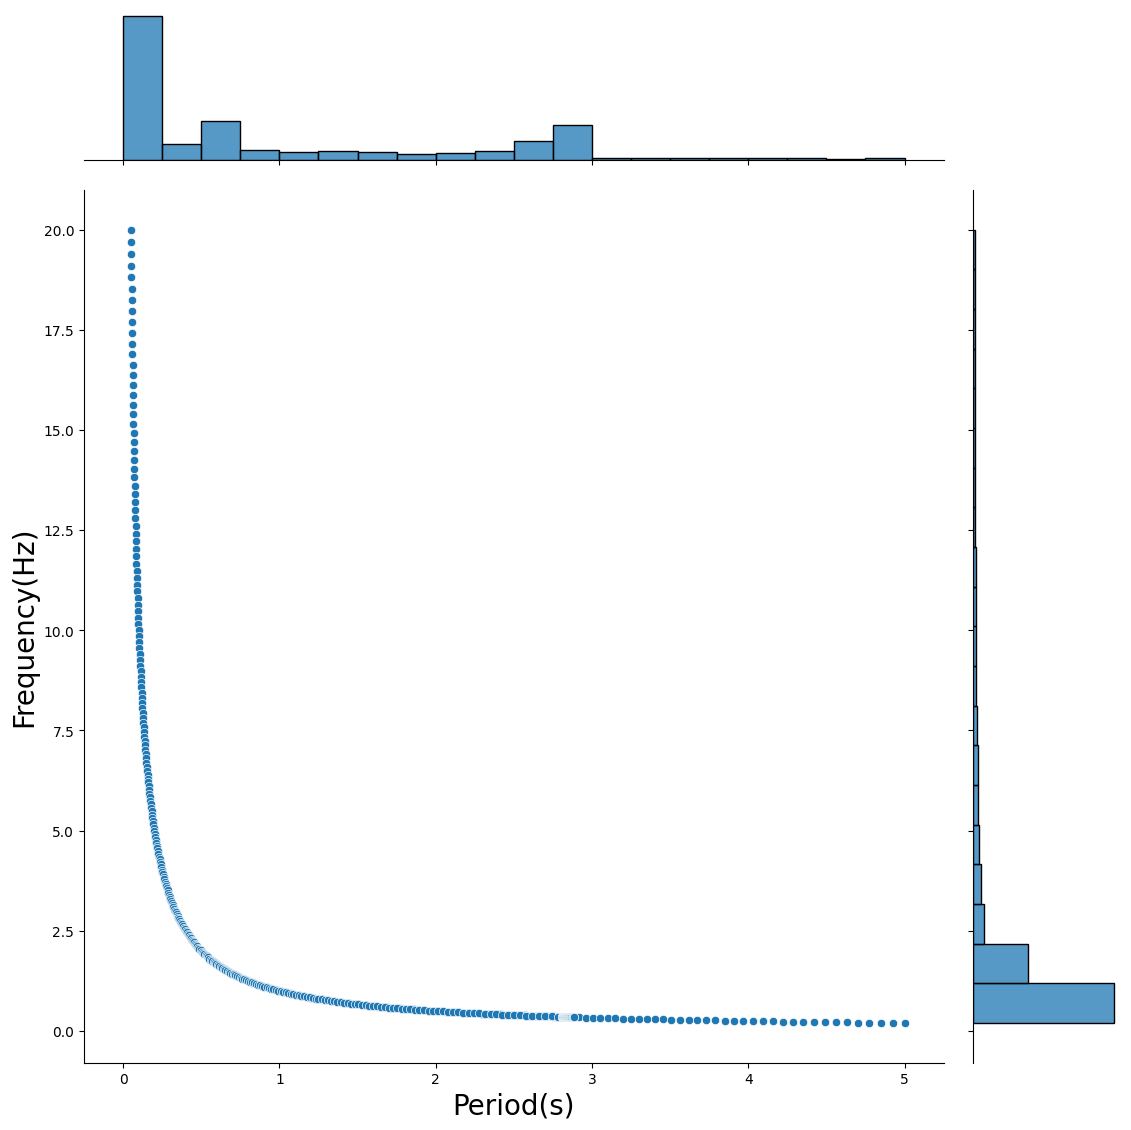

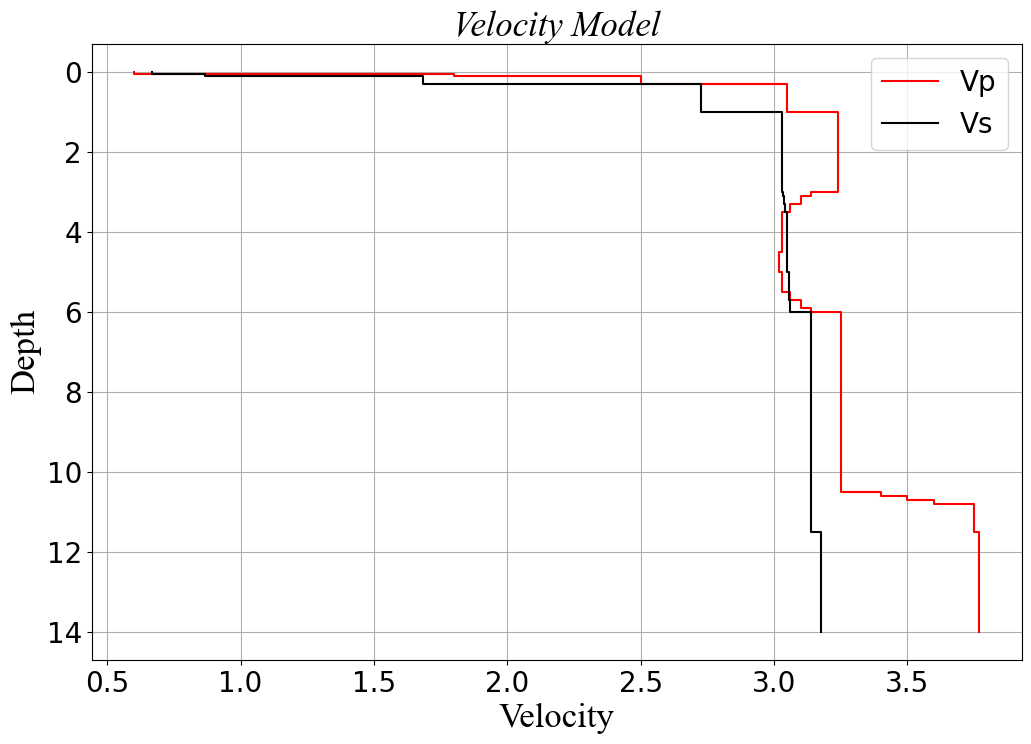

{'vs': array([0.66596543, 0.8661362 , 1.68394028, 2.72716379, 3.03122767,
        3.03349924, 3.03721973, 3.04003796, 3.04708619, 3.05006365,
        3.0552941 , 3.05728968, 3.05955064, 3.06079522, 3.13899983,
        3.13899983, 3.13899983, 3.13899983, 3.13899983, 3.17666783]),
 'vp': array([2.04626203, 2.29979488, 3.22063597, 4.6038758 , 5.10405619,
        5.1079627 , 5.11436623, 5.11922117, 5.13137938, 5.13652247,
        5.14556727, 5.14902151, 5.15293734, 5.15509389, 5.2920255 ,
        5.2920255 , 5.2920255 , 5.2920255 , 5.2920255 , 5.35895698]),
 'rho': array([1.92581028, 2.02617375, 2.26890808, 2.47668905, 2.55101495,
        2.55163546, 2.55265421, 2.55342793, 2.55537061, 2.55619458,
        2.55764685, 2.55820255, 2.55883323, 2.5591809 , 2.58175243,
        2.58175243, 2.58175243, 2.58175243, 2.58175243, 2.59315799]),
 'thick': array([0.057, 0.043, 0.2  , 0.7  , 2.   , 0.1  , 0.2  , 0.2  , 1.   ,
        0.5  , 0.5  , 0.2  , 0.2  , 0.1  , 4.5  , 0.1  , 0.1  , 0.1  ,
        

In [4]:
ADsurf_data_path = "./data/02_FRIUL7W/input/FRIUL7W-structure.txt"
FRIUL7W_model = np.loadtxt(os.path.join(ADsurf_data_path))
layer_num = 20
thick_true = FRIUL7W_model[:,1][:layer_num]
rho_true   = FRIUL7W_model[:,2][:layer_num]
vp_true    = FRIUL7W_model[:,3][:layer_num]
vs_true    = FRIUL7W_model[:,5][:layer_num]

# data distribution
pvs_obs = np.loadtxt(os.path.join(data_path,"input/disper.txt"))
plot_dataDistribution(pvs_obs,save_path="",show=True)


initial_model = Init_model(
                        model_param = model_parameter,
                        pvs_obs=pvs_obs,
                        vp=vp_true,
                        rho=rho_true,
                        thick=thick_true # if the layering method =="",you may need to specified the thickness manually
                        )

plot_velModel(thick=initial_model.init_model["thick"],
            vp = vs_true,
            vs= initial_model.init_model["vs"],
            )
initial_model.init_model

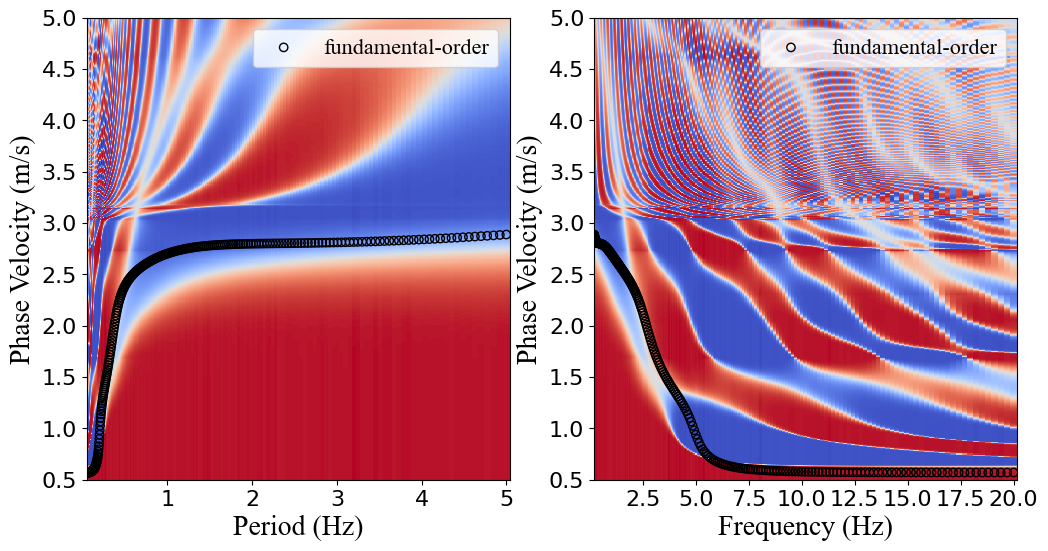

In [5]:
# calculate the determinant dipersion function
F = initial_model._cal_determinant(sampling_method="log-wavelength",sampling_num=300)
# post process
disp_matrix_symbol = torch.sign(F.detach())
disp_matrix = F/(torch.max(F,dim=0).values - torch.min(F,dim=0).values)
disp_matrix_compress = (1e-31)**torch.abs(disp_matrix)-1
disp_matrix_compress = disp_matrix_compress/(torch.max(disp_matrix_compress,dim=0).values - torch.min(disp_matrix_compress,dim=0).values)
disp_matrix_compress = disp_matrix_compress*disp_matrix_symbol
disp_matrix_plot = disp_matrix_compress
disp_matrix_plot[disp_matrix_plot>0] = disp_matrix_plot[disp_matrix_plot>0]/disp_matrix_plot.max()
disp_matrix_plot[disp_matrix_plot<0] = disp_matrix_plot[disp_matrix_plot<0]/np.abs(disp_matrix_plot.min())
disp_matrix_plot = disp_matrix_plot.numpy()
tlist = tensor2numpy(initial_model.tlist)
vlist = tensor2numpy(initial_model.vlist)

plot_param = {
    'label_font':{
                'fontsize':20,
                'color':'k',
                'family':'Times New Roman',
                'weight':'normal',
                # 'style':'italic',
                },
    'cbar_font':{
                'fontsize':16,
                'color':'k',
                'family':'Times New Roman',
                'weight':'normal',
                # 'style':'italic',
    },
    "legend_font":{
        'family': 'Times New Roman',  # 字体
        'style': 'normal',
        'size': 16,  # 字号
        'weight': "normal",  # 是否加粗，不加粗
    },
    'tick_fontsize':16,
}
plot_param = dictToObj(plot_param)


plt.figure(figsize=(12,6))
T_list,V_list_T     = np.meshgrid(tlist,vlist)
Freq_list,V_list_F  = np.meshgrid(1/tlist,vlist)
cmap="coolwarm"
plt.subplot(121)
plt.pcolormesh(T_list,V_list_T,disp_matrix_plot,cmap=cmap)
mask = pvs_obs[:,2]==0
plt.scatter(pvs_obs[:,0][mask],pvs_obs[:,1][mask],marker="o",edgecolors='black',facecolor="none",label="fundamental-order")
plt.ylim(vmin,vmax)
plt.xticks(fontsize=plot_param.tick_fontsize)
plt.yticks(fontsize=plot_param.tick_fontsize)
plt.xlabel("Period (Hz)",fontdict=plot_param.label_font)
plt.ylabel("Phase Velocity (m/s)",fontdict=plot_param.label_font)
plt.legend(loc='upper right',prop=plot_param.legend_font,frameon=True)

plt.subplot(122)
plt.pcolormesh(Freq_list,V_list_F,disp_matrix_plot,cmap=cmap)
mask = pvs_obs[:,2]==0
plt.scatter(1/pvs_obs[:,0][mask],pvs_obs[:,1][mask],marker="o",edgecolors='black',facecolor="none",label="fundamental-order")
plt.ylim(vmin,vmax)
plt.xticks(fontsize=plot_param.tick_fontsize)
plt.yticks(fontsize=plot_param.tick_fontsize)
plt.xlabel("Frequency (Hz)",fontdict=plot_param.label_font)
plt.ylabel("Phase Velocity (m/s)",fontdict=plot_param.label_font)
plt.legend(loc='upper right',prop=plot_param.legend_font,frameon=True)
plt.show()

### MonteCarlo Search for initial model
default not run (you can uncommont it)

In [6]:
MonteCarlo_model = init_model_MonteCarlo(
                                        model_parameter,
                                        initial_model,
                                        sampling_num=100,
                                        sampling_method="normal",
                                        vsrange_sign="add",
                                        vsrange=[-1,1],
                                        sigma_vs= 30,
                                        sigma_thick= 20,)

MonteCarlo: Iter:99,loss:0.066709: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


### plot all the initial model

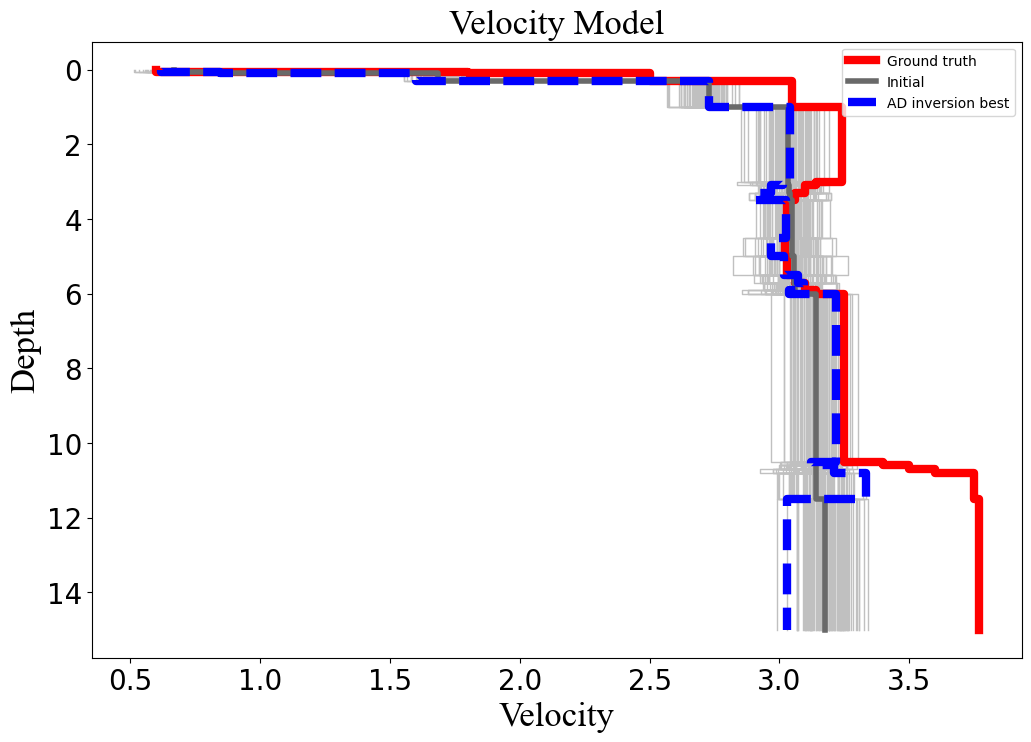

In [7]:
# figure to show the searching result
MonteCarlo_vs = MonteCarlo_model.MonteCarlo_model["vs"]
MonteCarlo_thick = MonteCarlo_model.MonteCarlo_model["thick"]
MonteCarlo_vp = MonteCarlo_model.MonteCarlo_model["vp"]
MonteCarlo_rho = MonteCarlo_model.MonteCarlo_model["rho"]
MonteCarlo_initVs = MonteCarlo_model.MonteCarlo_model["vs"][0]
MonteCarlo_initthick = MonteCarlo_model.MonteCarlo_model["thick"][0]
loss_lists = MonteCarlo_model.MonteCarlo_model["loss"]
best_MonteCarlo = np.argmin(np.array(loss_lists))
plot_allModel(vs_inversion=MonteCarlo_vs,thick_inversion=MonteCarlo_thick,
            vs_true=vs_true,thick_true=thick_true,
            vs_init=MonteCarlo_initVs,thick_init=MonteCarlo_initthick,
            vs_matlab=[],thick_matlab=[],
            best_index=best_MonteCarlo,
            plot_all=True,
            largest_depth=15
            # save_path=os.path.join(config.save_path,"007_inversion_result.png")
            )

# redefine the initial model paramters
initial_model.init_model["vs"] = MonteCarlo_vs
initial_model.init_model["vp"] = MonteCarlo_vp
initial_model.init_model["thick"] = MonteCarlo_thick
initial_model.init_model["rho"] = MonteCarlo_rho

## 4. inversion

In [8]:
inversion_model = inversion(
                        model_param = model_parameter,
                        inv_param = inversion_parameter,
                        init_model=initial_model,
                        pvs_obs=np.ones((MonteCarlo_vs.shape[0],pvs_obs.shape[0],2))*pvs_obs[:,:2],
                        vsrange_sign="mul",
                        vsrange=[0.1,2.5],
                        AK135_data=[],
                        device="cuda:0"
                        )

 66%|██████▌   | 1320/2000 [09:17<04:30,  2.52it/s]

## 5. plotting

In [10]:
if not os.path.exists(os.path.join(data_path,"output/figure")):
    os.makedirs(os.path.join(data_path,"output/figure"))
if not os.path.exists(os.path.join(data_path,"output/data")):
    os.mkdir(os.path.join(data_path,"output/data"))

### Misfit
for a same learning rate, not all the initial model can be converged with the same iterations， but we can select some of the coverged model to do more research

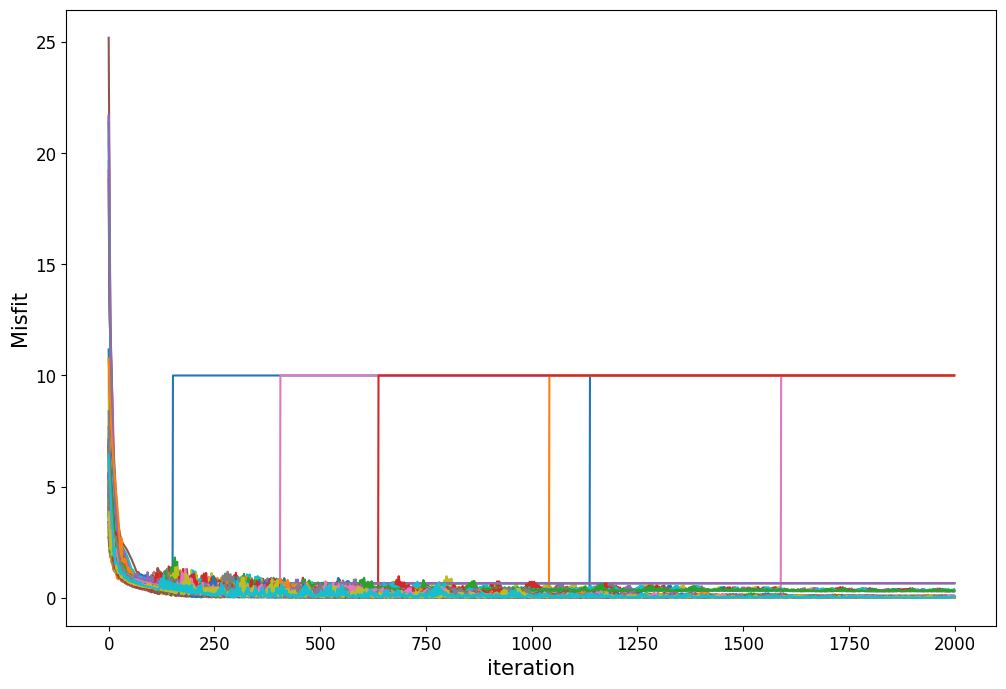

In [11]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12,8))
plt.plot(inversion_model.inv_process["loss"])
plt.xlabel("iteration",fontsize=15)
plt.ylabel("Misfit",fontsize=15)
plt.tick_params(labelsize="large")
# plt.ylim(0,1)
plt.savefig(os.path.join(data_path,"output/figure/loss_curve.png"))
plt.show()

### Minimum misift

In [12]:
best_index = np.argmin(inversion_model.inv_process["loss"],axis=0)
loss_lists = list2numpy(inversion_model.inv_process["loss"])
best_loss = np.zeros(best_index.shape[0])
for i in range(len(best_index)):
    best_loss[i] = loss_lists[best_index[i],i]
best_iter = np.argmin(best_loss)
best_loss[best_iter]

0.000814497412648052

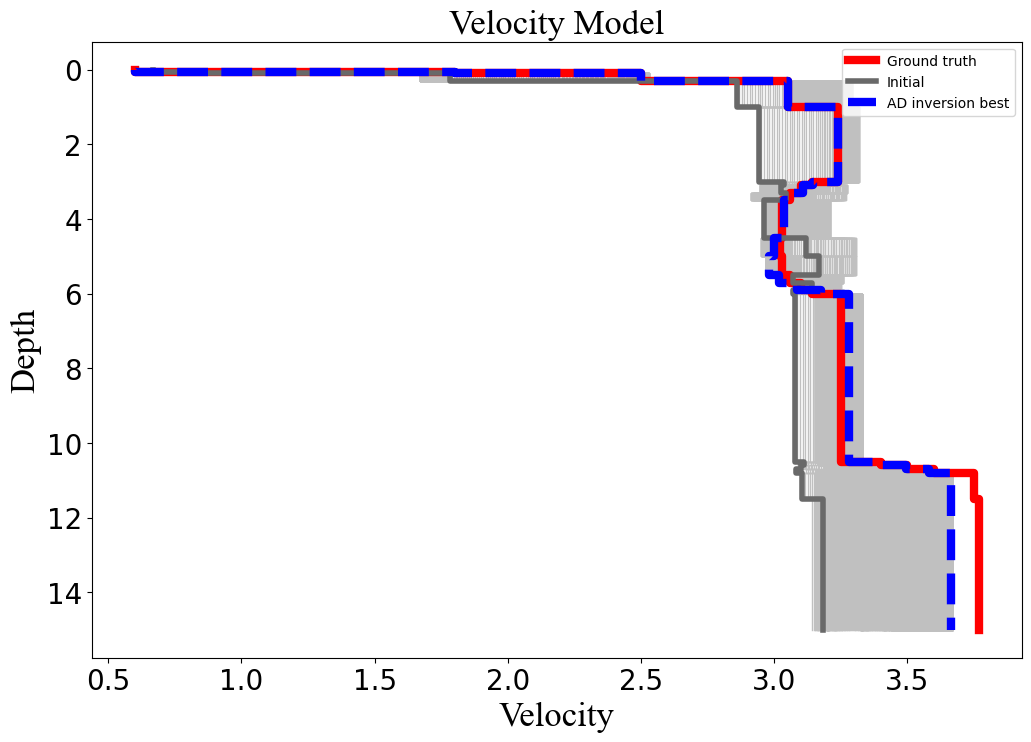

In [13]:
iter_vs = list2numpy(inversion_model.inv_process["iter_vs"])
vs_init = list2numpy(initial_model.init_model["vs"])
thick_init = list2numpy(initial_model.init_model["thick"])

if inversion_method == "VsAndThick":
    iter_thick = list2numpy(inversion_model.inv_process["iter_thick"])
else:
    iter_thick = np.ones_like(iter_vs)*thick_init
vs_matlab = []
thick_matlab = []
best_num = np.argmin(list2numpy(inversion_model.inv_process["loss"]),axis=0)
# thick_true = np.array([0.005,0.005,0.005])
# vs_true = np.array([0.3,0.22,0.4])

i = best_iter
plot_allModel(vs_inversion=iter_vs[:,i,:],thick_inversion=iter_thick[:,i,:],
            vs_true=vs_true,thick_true=thick_true,
            vs_init=vs_init[i],thick_init=thick_init[i],
            vs_matlab=vs_matlab,thick_matlab=thick_matlab,
            best_index=best_num[i],
            plot_all=True,
            save_path=os.path.join(data_path,"output/figure/Inverted_result.png".format(i)),
            largest_depth=15,
            show=True
            )

In [14]:
import os 
import json 

def numpy2list(a):
    """
        transform numpy data into tensor
    """
    if not isinstance(a,list):
        return a.tolist()
    else:
        return a

config_res = {
    "model_param":{
        "vmin":model_parameter.vmin,
        "vmax":model_parameter.vmax,
        "dc":model_parameter.dc,
        "tmin":model_parameter.tmin,
        "tmax":model_parameter.tmax,
        "Nt":model_parameter.Nt,
        "layering_method":model_parameter.layering_method,
        "initialize_method":model_parameter.initialize_method,
        "layering_ratio":model_parameter.layering_ratio,
        "depth_factor":model_parameter.depth_factor,
        "layer_number":model_parameter.layer_number,
        "vp_vs_ratio":model_parameter.vp_vs_ratio,
        "rho":model_parameter.rho
    },
    "inv_param":{
        "inversion_method":inversion_parameter.inversion_method,
        "wave":inversion_parameter.wave,
        "algorithm":inversion_parameter.algorithm,
        # "itype":inversion_parameter.itype,
        "mode":inversion_parameter.mode,
        "compress":inversion_parameter.compress,
        "compress_method":inversion_parameter.compress_method,
        "lr":inversion_parameter.lr,
        "damp_vertical":inversion_parameter.damp_vertical,
        "damp_horizontal":inversion_parameter.damp_horizontal,
        "iteration":inversion_parameter.iteration,
        "step_size":inversion_parameter.step_size,
        "gamma":inversion_parameter.gamma,
        "optimizer":inversion_parameter.optimizer
    }
}

model_res = {
    "inv_model":{
        "vs":numpy2list(inversion_model.inv_model["vs"]),
        "vp":numpy2list(inversion_model.inv_model["vp"]),
        "rho":numpy2list(inversion_model.inv_model["rho"]),
        "thick":numpy2list(inversion_model.inv_model["thick"])
    },
    "init_model":{
        "vs":numpy2list(initial_model.init_model["vs"]),
        "vp":numpy2list(initial_model.init_model["vp"]),
        "rho":numpy2list(initial_model.init_model["rho"]),
        "thick":numpy2list(initial_model.init_model["thick"])
        },
    "inv_process":{
        "iter_vs":numpy2list(inversion_model.inv_process["iter_vs"]),
        "iter_thick":numpy2list(inversion_model.inv_process["iter_thick"]),
        "loss":numpy2list(inversion_model.inv_process["loss"])
    }
}
with open(os.path.join(data_path,"output/data/model.json"),"w") as f:
    json.dump(model_res,f)
    
with open(os.path.join(data_path,"output/data/config.json"),"w") as f:
    json.dump(config_res,f)
